<a href="https://colab.research.google.com/github/JordanFoss/STAT3007_Project/blob/main/TimeDistributedCNN%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 2358, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 2358 (delta 24), reused 40 (delta 18), pack-reused 2307
Receiving objects: 100% (2358/2358), 331.04 MiB | 23.16 MiB/s, done.
Resolving deltas: 100% (544/544), done.
Checking out files: 100% (1900/1900), done.
/content/STAT3007_Project


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import scipy
import numpy as np
import librosa
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import pandas as pd
import glob

In [3]:
# fourier transform
def spectral_decomposition(sample,sampling_rate, eps = 1e-14, title = ' title placeholder', visualise = False):
    frequencies, times, spectrogram = scipy.signal.spectrogram(sample,fs = sampling_rate)

    
    
    
    if visualise:
      specgram = plt.pcolormesh(times, frequencies, np.log(spectrogram + eps),shading = 'auto')
      plt.clim(-40, -5)
      
      plt.colorbar(specgram)
      #plt.imshow(np.log(spectrogram))
      plt.ylabel('Frequency [Hz]')
      plt.xlabel('Time [sec]')
      plt.title(title)
      plt.show()
    
    return frequencies, times, np.log(spectrogram+ eps)

In [4]:
# produce emotion label

# 0 - calm; 1 - happy; 2 - sad; 3 - angry; 4 - surprised
target_map = {'02':0,'03':1,'04':2,'05':3,'08':4}

def target_generation(file_name):
  labels = file_name.split('.')[0].split('-')
  emotion = labels[0]

  if emotion not in target_map:
    return None

  return target_map[emotion]

In [31]:
# load samples
X = []
y = []

min_time = 41241

max_time = 0
max_sample = 0
for folder_name in glob.glob('./Audio_Speech_Actors_01-24/*'):
  for actor_folder in glob.glob(folder_name + '/*'):
    for sample_path in glob.glob(actor_folder + '/*'):
      
      sample_name = sample_path.split('/')[-1]
      file_format = sample_name.split('.')[-1]

      if file_format != 'wav' or sample_name[:2] not in target_map or sample_name[3:5] == '01':
        continue

      sample, sampling_rate = librosa.load(sample_path, sr = None)
      sampling_time = sample.shape[0]/sampling_rate

      frequencies, times, spectrogram = spectral_decomposition(sample, sampling_rate)

      if sampling_time < min_time:
        min_time = sampling_time
        min_sample = (sample,sampling_rate, sample_path)

      if sampling_time > max_time:
        max_time = sampling_time
        max_sample = (sample,sampling_rate, sample_path)
      
      target = target_generation(sample_name)

      if target != None:
        X.append(spectrogram)
        y.append(target)
    


# Pre-Process

##Current Problem
The time steps for speech data is not the same.

proposed solution:
1. test data - no changes
2. training data - pad all the samples to max length. Since we want our network to be independent of audio length, we can do data augmentation to break them apart. (source https://arxiv.org/pdf/1607.02857.pdf)

3. must read: effect of padding on CNN and LSTM (https://arxiv.org/pdf/1903.07288.pdf)
 * Acoording to the paper, prepadding is good for LSTM and CNN. So we choose __pre-padding__ the samples

In [ ]:
print(max_time)
print(max_sample[2])
print(min_time)
print(min_sample[2])

5.105104166666667
./Audio_Speech_Actors_01-24/Female/Actor_24/05-02-02-02-24.wav
3.003
./Audio_Speech_Actors_01-24/Male/Actor_13/02-02-02-01-13.wav


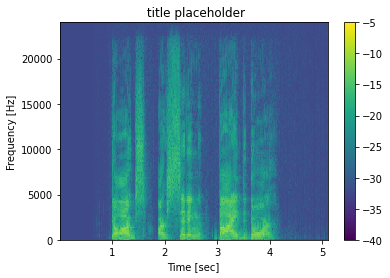

In [ ]:
a,b,c = spectral_decomposition(max_sample[0],max_sample[1],visualise = True)

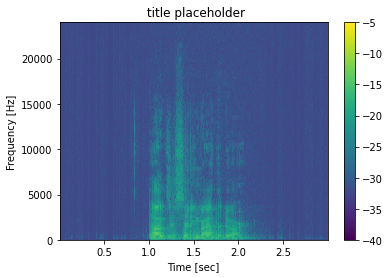

In [ ]:
a,b,c = spectral_decomposition(min_sample[0],min_sample[1],visualise = True)

## Padding

In [32]:
# find maximum and minimum duration
def find_min_max():

  min_time = 41241
  max_time = 0
  min_sample = 0
  max_sample = 0
  for folder_name in glob.glob('./Audio_Speech_Actors_01-24/*'):
    for actor_folder in glob.glob(folder_name + '/*'):
      for sample_path in glob.glob(actor_folder + '/*'):
        sample_name = sample_path.split('/')[-1]
        file_format = sample_name.split('.')[-1]
        if file_format != 'wav' or sample_name[:2] not in target_map or sample_name[3:5] == '01':
          continue
        
        sample, sampling_rate = librosa.load(sample_path, sr = None)
        sampling_time = sample.shape[0]/sampling_rate

        if sampling_time < min_time:
          min_time = sampling_time
          min_sample = sample.shape[0]

        if sampling_time > max_time:
          max_time = sampling_time
          max_sample = sample.shape[0]

  return min_time, max_time, min_sample, max_sample

In [33]:
min_time, max_time, min_sample, max_sample = find_min_max()


Now that we have the maximum duration of the dataset, we can start pre-padding

In [34]:
def pre_pad(samples, max_sample):
  sample_duration = samples.shape[0]

  num_to_pad = max_sample - sample_duration
  padded_sample = np.pad(samples,(num_to_pad,0),'constant', constant_values = 0)

  return padded_sample

let's inspect how the pre-pad works by choosing a random file and inspect the padded spectrogram

In [35]:
test_sample, test_rate = librosa.load('/content/STAT3007_Project/Audio_Speech_Actors_01-24/Female/Actor_08/02-02-01-02-08.wav', sr= None)

In [36]:
test_sample_pad = pre_pad(test_sample, max_sample)

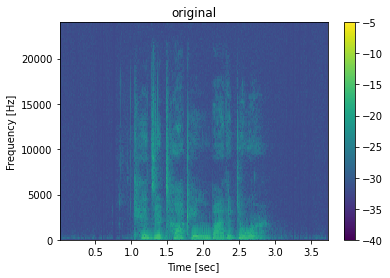

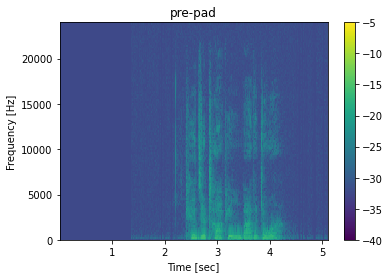

In [37]:
test_freq, test_times, test_spec = spectral_decomposition(test_sample,test_rate, visualise = True, title = 'original')
plt.figure()
test_freq, test_times, test_spec = spectral_decomposition(test_sample_pad,test_rate, visualise = True, title = 'pre-pad')

Apply padding on all the data

In [38]:
def load_samples(max_sample):
  # load samples
  X = []
  y = []

  for folder_name in glob.glob('./Audio_Speech_Actors_01-24/*'):
    for actor_folder in glob.glob(folder_name + '/*'):
      for sample_path in glob.glob(actor_folder + '/*'):
        
        sample_name = sample_path.split('/')[-1]
        file_format = sample_name.split('.')[-1]

        if file_format != 'wav' or sample_name[:2] not in target_map or sample_name[3:5] == '01':
          continue

        sample, sampling_rate = librosa.load(sample_path, sr = None)
        
        padded_sample = pre_pad(sample, max_sample)



        frequencies, times, spectrogram = spectral_decomposition(padded_sample, sampling_rate)
        
        target = target_generation(sample_name)

        if target != None:
          X.append(spectrogram)
          y.append(target)
  
  return X, y


In [39]:
X,y = load_samples(max_sample)

## Clean-up data

In [40]:
# convert torch type
X = torch.tensor(X)

# (batch_size, channels, freq, time)
X = X.reshape(X.shape[0],1,X.shape[1],X.shape[2])

y = torch.tensor(y)

Since our convNet takes $129\times 129$ "image", we want to somewhat adjust our time length so that the convNet can iterate through the specotrgam over time completely (without overlap). 

This means that we want to make our input spectrogram to have timestep of a multiple of $129$

In [48]:
# first, let's consider truncating it to the nearest integer diviser
# this works because the original data has 0.5 second of radio slience before the actual audio.
truncate_multiple = X.shape[3] // 129

In [56]:
# in fact, the length of the sample is only shortened by 0.0002 second as shown below,
# so shortening it eliminates the radio slience
max_time - ((max_sample-truncate_multiple) /sampling_rate)

0.00016666666666687036

### Dimension truncation
Now we implement the idea of truncating the data as outlined above

In [58]:
def truncate_sample(X, conv_input_size):
  new_time_size = (X.shape[3]//conv_input_size) * conv_input_size

  time_to_truncate = X.shape[3] - new_time_size

  return X[:,:,:,time_to_truncate:]


In [61]:
X = truncate_sample(X,129)

# Architecture building

1. build a CNN
2. build a RNN embedded with CNN

Here, we are going to have 8 time steps in the RNN. In each time step, we take a $129\times 129$ truncated spectrogram as an input to the CNN, then the flattened output of CNN will be the input of RNN.

## CNN

In [70]:
# convolutional net

# input: 129x129
#output: 30x30 for 32 filters
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.flatten = nn.Flatten()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(32, 32, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
        )

    def forward(self, x, inspect_feature = False):

      conv_x = self.conv(x)
      conv_x_flat  = self.flatten(conv_x)
      if inspect_feature:
        return conv_x
      return conv_x_flat

In [71]:
# example usage
CNN = ConvNet()
cnn_out = CNN(X[:30,:,:,:129], inspect_feature = True)

In [72]:
cnn_out.shape

torch.Size([30, 32, 30, 30])

This means that we have a total of $30\times 30\times 32$ neurons as output of CNN

## RNN

In [112]:
# RNN combined with CNN
class LRCN(nn.Module):
    def __init__(self, num_inputs):
        super(LRCN, self).__init__()

        self.lstm_layers = nn.LSTM(num_inputs,100,num_layers = 2)
        self.linear = nn.Sequential(nn.Linear(100, 5),
                                    nn.Sigmoid())

    def forward(self, x,CNN, step_size, use_cuda = False):

      if use_cuda:
        h_t = torch.zeros(2,x.shape[0] ,100, dtype=torch.float).to(x.device)
        c_t = torch.zeros(2,x.shape[0], 100, dtype=torch.float).to(x.device)

      else:
        h_t = torch.zeros(2,x.shape[0], 100, dtype=torch.float)
        c_t = torch.zeros(2,x.shape[0], 100, dtype=torch.float)

      current_time = 0
      for look_ahead_time in range(step_size,x.shape[3]+1, step_size):

        x_t = x[:,:,:,current_time:look_ahead_time]
        current_time = look_ahead_time
        conv_x_flat = CNN(x_t)

        conv_x_flat = conv_x_flat.reshape(1,conv_x_flat.shape[0],conv_x_flat.shape[1])

        output, (h_t, c_t) = self.lstm_layers(conv_x_flat, (h_t, c_t))
        
      decision_vec = self.linear(output[0])
      return decision_vec

In [113]:
# Example usage
CNN = ConvNet()
num_inputs = 32*30*30
step_size = 129

ConvLSTM = LRCN(num_inputs)

batch = X[:30]

output = ConvLSTM(batch,CNN,129)